<h1 style="color:#FF00A6; font-weight:bold; font-family:sans-serif;">
  Snappfood Data Analyst Task
</h1>

<h3 style="color:#F9FAFB; font-family:sans-serif;">
  Task 2 – <em>Grading Model</em>
</h3>

<p style="color:#EBEDF0; font-size:14px; font-family:sans-serif;">
  Develop a predictive model to estimate restaurant grades based on historical data and identify the most influential features.
</p>
<br>
<hr style="color:#FF00A6;">

# Imports & Setup

In [164]:
# Import the importlib module to check if the required libraries are installed
import importlib.util

# List of required libraries
required_libraries = ['requests', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scipy', 'imblearn', 'joblib']

# Install the required libraries if they are not already installed
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        %pip install {lib}

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import zscore, skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, cohen_kappa_score
from imblearn.over_sampling import SMOTE


Note: you may need to restart the kernel to use updated packages.


# Prepare Dataset

## Downlaod from Google Sheets

In [2]:
def download_sheet_as_csv(spreadsheet_id, gid, output_path):
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export"
    params = {
        "format": "csv",
        "gid": gid
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        with open(output_path, "wb") as f:
            f.write(response.content)
        print(f"Sheet downloaded and saved to '{output_path}'")
    else:
        print(f"Failed to download sheet. Status code: {response.status_code}")

# Replace with your actual spreadsheet ID and sheet GID
SPREADSHEET_ID = "1ic4RLD_r4ASfl7nRk2ctagH_98j2sPDYN7IB4n6n9e8"
GID = "681255617"  # GID of Task 1 sheet
OUTPUT_FILE = "./task2_dataset.csv"

download_sheet_as_csv(SPREADSHEET_ID, GID, OUTPUT_FILE)


Sheet downloaded and saved to './task2_dataset.csv'


## Load Dataset

In [6]:
df = pd.read_csv("./task2_dataset.csv")


# EDA

## Preview

In [24]:
# Display the first few rows
df.head()


,ID,Search Count,Survey,Google Sense,Branch Counts,Marketing area,Grade
0,1001,5435,8,3133.2,2,14,1
1,1002,6938,35,6816.6,35,6,1
2,1004,5008,6,339.7,0,29,2
3,1005,3100,0,838.5,0,20,3
4,1006,2760,3,1045.0,0,10,4


In [25]:
# Display the last few rows
df.tail()


,ID,Search Count,Survey,Google Sense,Branch Counts,Marketing area,Grade
394,1407,1752,0,19.8,0,1,4
395,1408,1610,0,17.0,0,7,4
396,1409,1405,0,17.0,0,11,4
397,1410,3013,0,16.0,0,15,4
398,1411,2717,0,0.0,0,19,4


## Summary

In [ ]:
# Get general info on the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              399 non-null    int64  
 1   Search Count    399 non-null    int64  
 2   Survey          399 non-null    int64  
 3   Google Sense    399 non-null    float64
 4   Branch Counts   399 non-null    int64  
 5   Marketing area  399 non-null    int64  
 6   Grade           399 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 21.9 KB


## Descriptive Overview

In [ ]:
# Show summary statistics for numerical columns
df.describe()


,ID,Search Count,Survey,Google Sense,Branch Counts,Marketing area,Grade
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,1207.634085,1860.162907,1.010025,464.430576,0.250627,16.080201,3.872180
std,118.037348,2048.160894,2.472949,962.123901,1.914594,9.258357,0.492357
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1106.500000,910.500000,0.000000,46.000000,0.000000,9.000000,4.000000
50%,1207.000000,1761.000000,0.000000,164.000000,0.000000,16.000000,4.000000
75%,1310.500000,2463.500000,1.000000,648.700000,0.000000,25.000000,4.000000
max,1411.000000,33153.000000,35.000000,10436.100000,35.000000,31.000000,4.000000


## Unique Values

In [28]:
# Display count of unique values for each column
print("Number of unique values per column:")
df.nunique()


Number of unique values per column:


ID                399
Search Count      339
Survey             12
Google Sense      322
Branch Counts       7
Marketing area     32
Grade               4
dtype: int64

## Grade Distribution

Grade distribution (1 = Best, 4 = Worst):
Grade
1      7
2      5
3     20
4    367
Name: count, dtype: int64


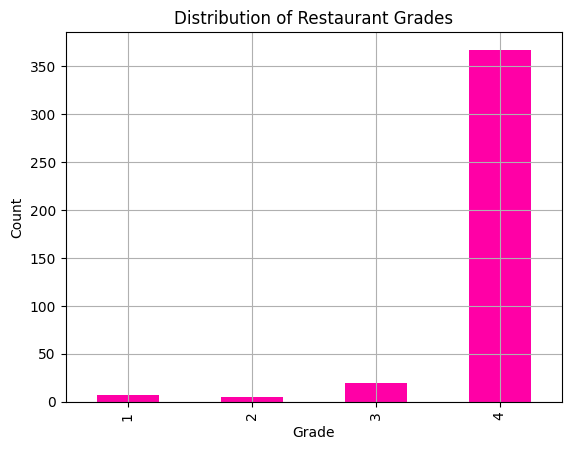

In [30]:
# Count and visualize grade frequency
grade_counts = df['Grade'].value_counts().sort_index()

print("Grade distribution (1 = Best, 4 = Worst):")
print(grade_counts)

# Plot
grade_counts.plot(kind='bar', color='#FF00A6')
plt.title("Distribution of Restaurant Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## Feature Distributions

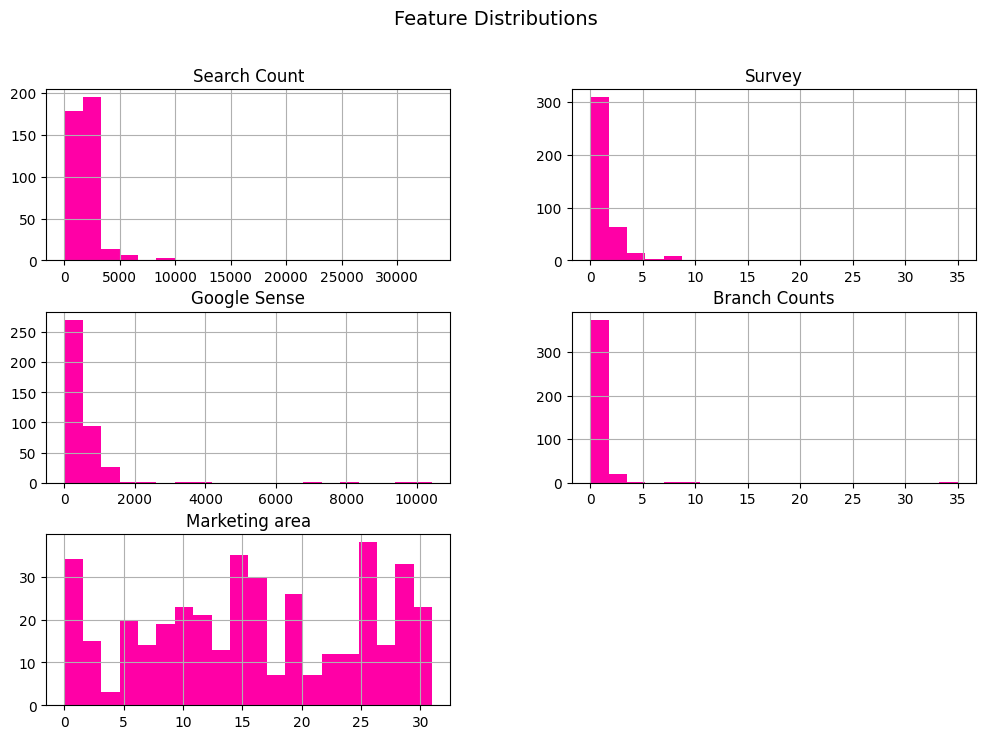

In [31]:
# Histograms for numeric features (excluding ID and Grade)
df.drop(columns=['ID', 'Grade']).hist(bins=20, figsize=(12, 8), grid=True, color="#FF00A6")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


## Correlation Heatmap

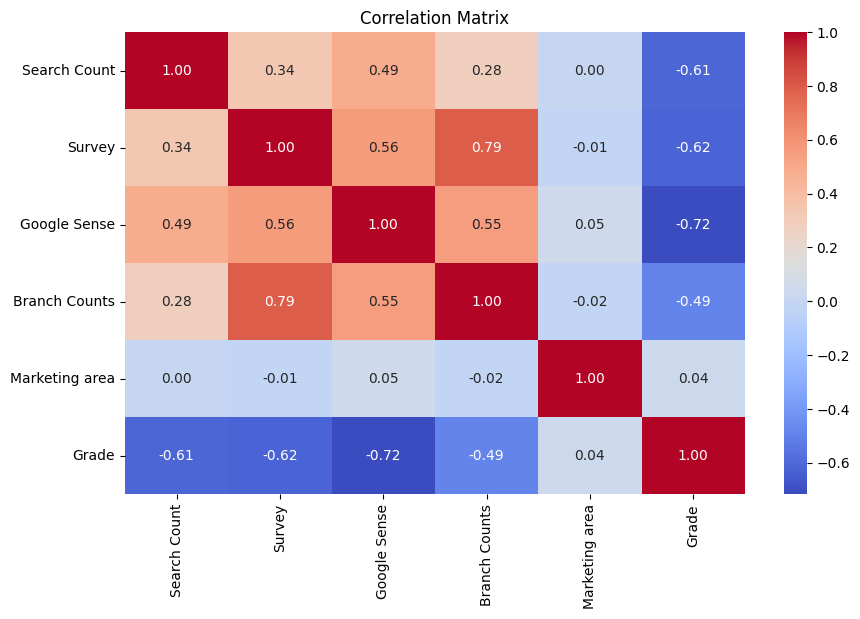

In [ ]:
plt.figure(figsize=(10, 6))
corr_matrix = df.drop(columns='ID').corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## Correlations with Target

In [ ]:
# Extract correlation with Grade
grade_corr = corr_matrix['Grade'].drop('Grade')  # Exclude self-correlation

# Sort correlations by absolute strength (descending)
sorted_corr = grade_corr.reindex(grade_corr.abs().sort_values(ascending=False).index)

# Display
print("Features most correlated with Grade:\n")
print(sorted_corr)


Features most correlated with Grade:

Google Sense     -0.716910
Survey           -0.622147
Search Count     -0.612953
Branch Counts    -0.493678
Marketing area    0.039184
Name: Grade, dtype: float64


## Boxplots (Grade vs. Feature)

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\654689455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Grade', y=feature, palette="pastel")


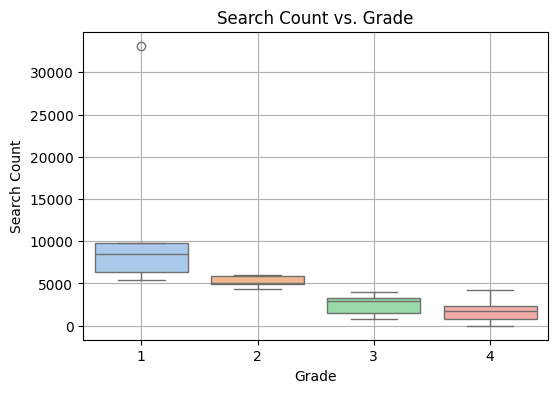

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\654689455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Grade', y=feature, palette="pastel")


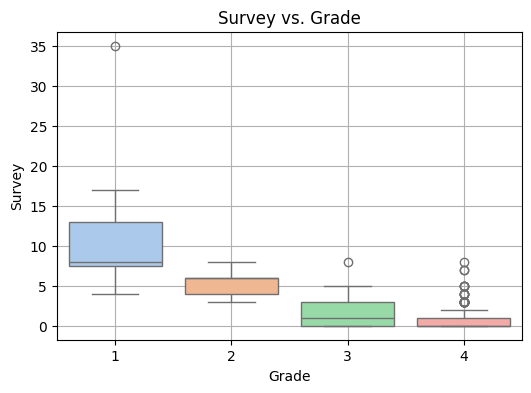

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\654689455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Grade', y=feature, palette="pastel")


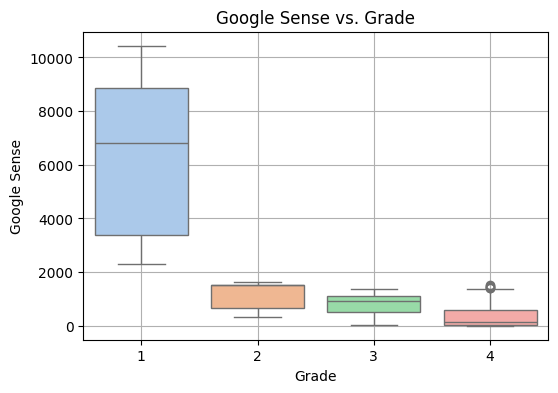

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\654689455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Grade', y=feature, palette="pastel")


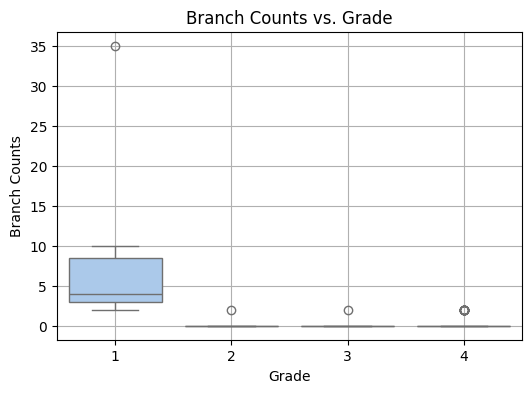

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\654689455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Grade', y=feature, palette="pastel")


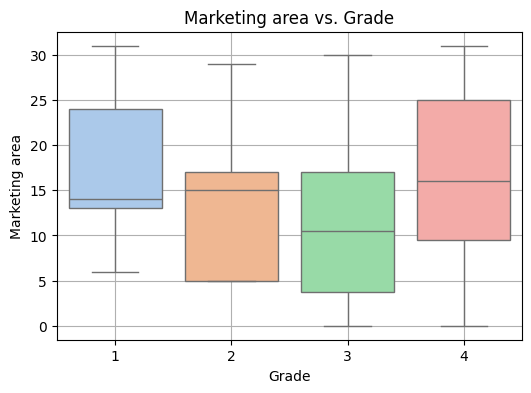

In [33]:
# Boxplots to analyze feature separation across grades
features = ['Search Count', 'Survey', 'Google Sense', 'Branch Counts', 'Marketing area']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Grade', y=feature, palette="pastel")
    plt.title(f"{feature} vs. Grade")
    plt.grid(True)
    plt.show()


## Violin Plots (Grade vs. Feature)

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\2087937891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Grade', y=feature, palette="Set2")


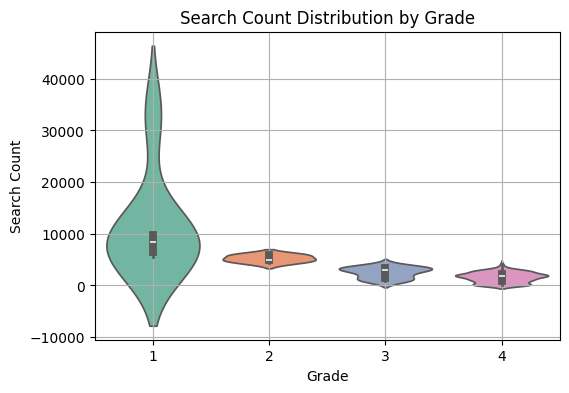

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\2087937891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Grade', y=feature, palette="Set2")


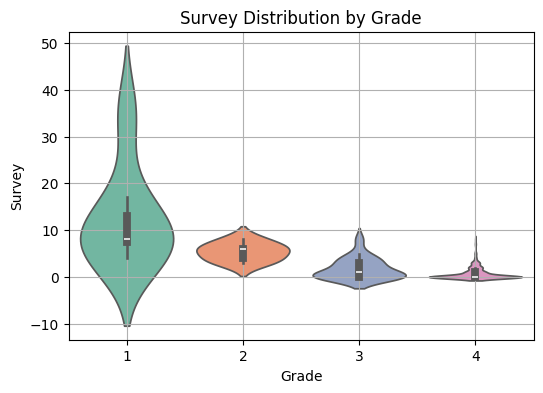

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\2087937891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Grade', y=feature, palette="Set2")


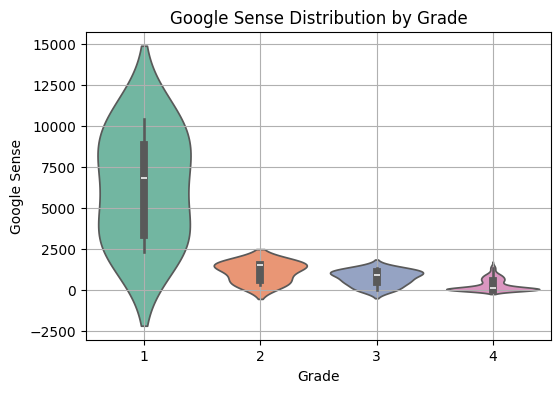

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\2087937891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Grade', y=feature, palette="Set2")


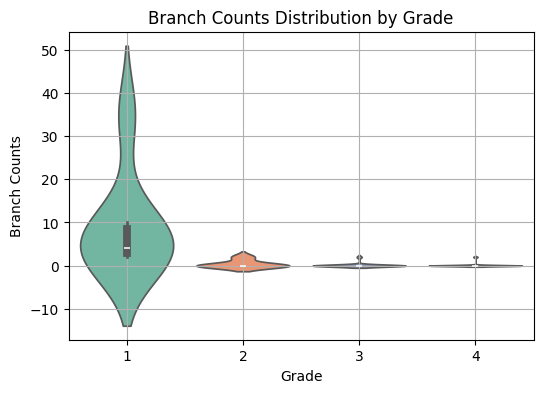

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\2087937891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Grade', y=feature, palette="Set2")


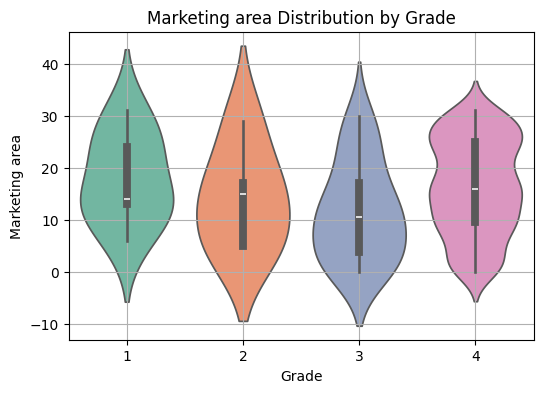

In [36]:
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df, x='Grade', y=feature, palette="Set2")
    plt.title(f"{feature} Distribution by Grade")
    plt.grid(True)
    plt.show()


## Outlier Detection (Z-Score)

In [ ]:
z_scores = df.drop(columns=['ID', 'Grade']).apply(zscore)
outliers = (np.abs(z_scores) > 3).sum()
print("Outlier Count per Feature (|Z| > 3):")
print(outliers)


Outlier Count per Feature (|Z| > 3):
Search Count      4
Survey            3
Google Sense      5
Branch Counts     3
Marketing area    0
dtype: int64


# Preprocessing

## Drop Unnecessary Columns

In [141]:
# Drop the ID column (not useful for modeling)
df_clean = df.drop(columns=['ID'])


## Detect & Correct Skewness

In [142]:
# Calculate skewness for all features except the target
skew_vals = df_clean.drop(columns=['Grade']).apply(skew)

# Sort skew values for clearer reporting
skew_vals_sorted = skew_vals.sort_values(ascending=False)

print("Skewness of numeric features (before transformation):\n")
print(skew_vals_sorted)

# Define skew threshold
skew_threshold = 0.75

# Identify right-skewed features
skewed_features = skew_vals[abs(skew_vals) > skew_threshold].index.tolist()

print("\nFeatures with high skewness (|skew| > 0.75, log1p applied):")
print(skewed_features)

# Apply log(1 + x) to reduce skewness
for feature in skewed_features:
    df_clean[feature] = np.log1p(df_clean[feature])


Skewness of numeric features (before transformation):

Branch Counts     15.551376
Search Count       9.408969
Survey             7.819464
Google Sense       7.161705
Marketing area    -0.088609
dtype: float64

Features with high skewness (|skew| > 0.75, log1p applied):
['Search Count', 'Survey', 'Google Sense', 'Branch Counts']


## Check Post-Transform Skew 

In [143]:
print("\nSkewness after transformation:")
print(df_clean[skewed_features].apply(skew).sort_values(ascending=False))



Skewness after transformation:
Branch Counts    5.211211
Survey           1.434845
Google Sense    -0.158571
Search Count    -2.490393
dtype: float64


## Separate Features & Target

In [144]:
# Separate features and target
X = df_clean.drop(columns=['Grade'])
y = df_clean['Grade']


## Feature Scaling

In [145]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Model Development

## Define Models

In [146]:
# Models to evaluate
model_defs = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]


## Define CV Strategy

In [147]:
# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## Define Fold Evaluation Function

In [148]:
# Train and evaluate on a single fold
def evaluate_fold(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    return acc, f1, y_pred


## Run CV + SMOTE for Each Model

c:\Users\Amirreza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Amirreza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Amirreza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Amirreza\AppData\Local\Progr


Logistic Regression Cross-Validation Results
Average Accuracy: 0.8598
Average F1 Score (macro): 0.6615

Combined Classification Report:
              precision    recall  f1-score   support

           1      0.750     0.857     0.800         7
           2      0.429     0.600     0.500         5
           3      0.233     0.700     0.350        20
           4      0.988     0.872     0.926       367

    accuracy                          0.860       399
   macro avg      0.600     0.757     0.644       399
weighted avg      0.939     0.860     0.890       399



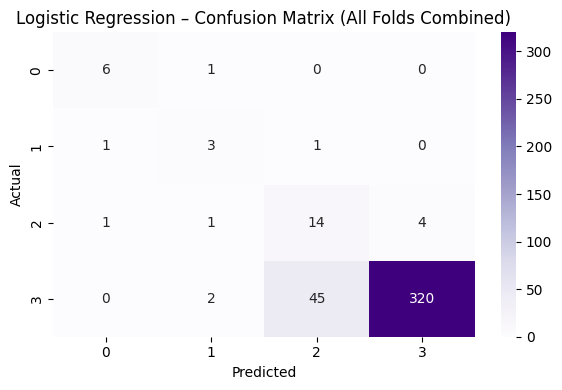

Quadratic Weighted Kappa (QWK): 0.7268

Decision Tree Cross-Validation Results
Average Accuracy: 0.9298
Average F1 Score (macro): 0.7444

Combined Classification Report:
              precision    recall  f1-score   support

           1      1.000     0.714     0.833         7
           2      0.667     0.800     0.727         5
           3      0.385     0.500     0.435        20
           4      0.972     0.959     0.966       367

    accuracy                          0.930       399
   macro avg      0.756     0.743     0.740       399
weighted avg      0.940     0.930     0.934       399



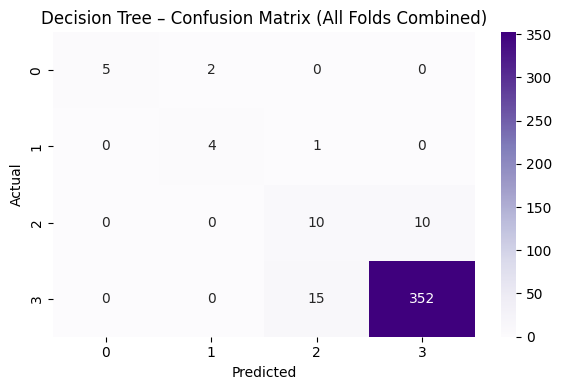

Quadratic Weighted Kappa (QWK): 0.8482

Random Forest Cross-Validation Results
Average Accuracy: 0.9599
Average F1 Score (macro): 0.8434

Combined Classification Report:
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         7
           2      1.000     0.800     0.889         5
           3      0.600     0.600     0.600        20
           4      0.978     0.981     0.980       367

    accuracy                          0.960       399
   macro avg      0.895     0.845     0.867       399
weighted avg      0.960     0.960     0.960       399



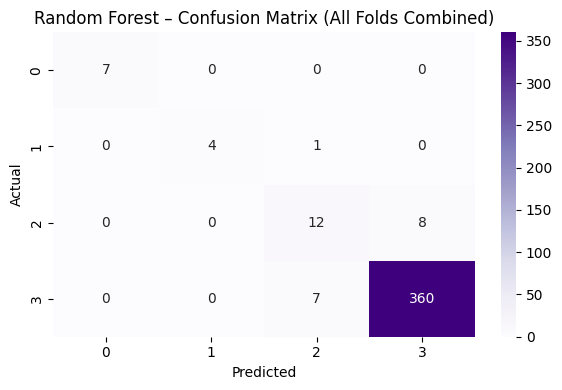

Quadratic Weighted Kappa (QWK): 0.9156


In [149]:
results = []

for name, model in model_defs:
    acc_scores = []
    f1_scores = []
    all_y_true = []
    all_y_pred = []

    for train_idx, val_idx in cv.split(X_scaled, y):
        X_train, y_train = X_scaled[train_idx], y.iloc[train_idx]
        X_val, y_val = X_scaled[val_idx], y.iloc[val_idx]

        # Apply SMOTE to training fold
        smote = SMOTE(random_state=42, k_neighbors=1)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        acc, f1, y_pred = evaluate_fold(model, X_resampled, y_resampled, X_val, y_val)
        acc_scores.append(acc)
        f1_scores.append(f1)
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"\n{name} Cross-Validation Results")
    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average F1 Score (macro): {avg_f1:.4f}")

    # Detailed Classification Report
    print("\nCombined Classification Report:")
    print(classification_report(all_y_true, all_y_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f"{name} – Confusion Matrix (All Folds Combined)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Quadratic Weighted Kappa (Ordinal-Aware Score)
    qwk = cohen_kappa_score(all_y_true, all_y_pred, weights='quadratic')
    print("Quadratic Weighted Kappa (QWK):", round(qwk, 4))

    results.append({
        'Model': name,
        'Accuracy': avg_acc,
        'F1 Score': avg_f1,
        'QWK': qwk,
        'Trained Model': model
    })


## Compare Results

In [150]:
# Compare models by performance
results_df = pd.DataFrame(results).drop(columns=['Trained Model'])
results_df = results_df.sort_values(by="F1 Score", ascending=False)
display(results_df)


,Model,Accuracy,F1 Score,QWK
2,Random Forest,0.959937,0.843354,0.915556
1,Decision Tree,0.929842,0.744419,0.848198
0,Logistic Regression,0.859778,0.661498,0.726830


# Feature Importance

## Select Best Model by QWK

In [163]:
# Use full results list to find the best model based on QWK
best_result = max(results, key=lambda r: r['QWK'])
best_model_name = best_result['Model']
best_model = best_result['Trained Model']

print(f"Selected Best Model by QWK: {best_model_name}")


Selected Best Model by QWK: Random Forest


## Importance Plot

C:\Users\Amirreza\AppData\Local\Temp\ipykernel_27600\2342188842.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="magma")


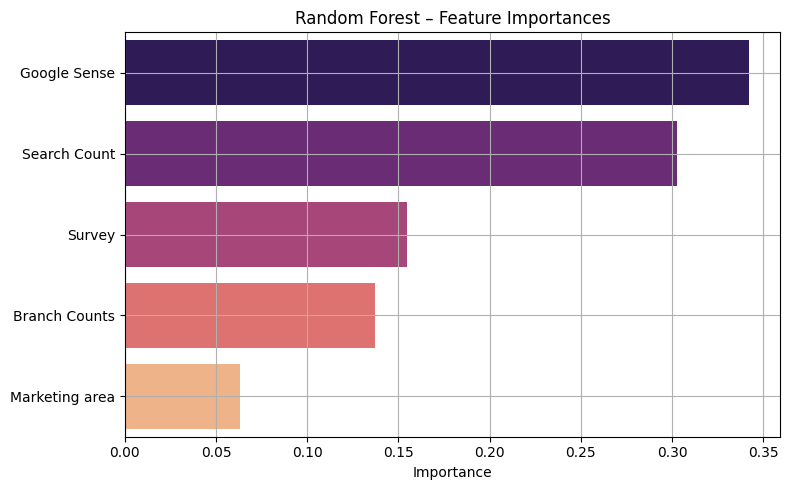


Influential Features (Descending Importance):

Google Sense: 0.3421
Search Count: 0.3029
Survey: 0.1547
Branch Counts: 0.1371
Marketing area: 0.0633


In [160]:
# Plot and print feature importances if the model supports it
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(importances)[::-1]

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="magma")
    plt.title(f"{best_model_name} – Feature Importances")
    plt.xlabel("Importance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print in descending order
    print("\nInfluential Features (Descending Importance):\n")
    for i in sorted_idx:
        print(f"{feature_names[i]}: {importances[i]:.4f}")

else:
    print(f"{best_model_name} does not support native feature_importances_")


# Save Model

In [ ]:
# Save the best model (selected by QWK)
joblib.dump(best_model, "task2_model.pkl")
print("Model saved as task2_model.pkl")

# Save the fitted scaler
joblib.dump(scaler, "task2_scaler.pkl")
print("Scaler saved as task2_scaler.pkl")


Model saved as task2_model.pkl
Scaler saved as task2_scaler.pkl
